# Lecture 5 - Benchmarking, Error Suppression & Error Mitigation

In [ ]:
# Install packages
!pip install git+https://github.com/qiskit-community/qiskit-experiments.git
!pip install qiskit_nature

In [64]:
import numpy as np
import qiskit as qs
import qiskit_ibm_runtime as IBM
import datetime as dt

import matplotlib.pyplot as plt

from qiskit.transpiler import generate_preset_pass_manager

# Modules Needed for Benchmarking Experiments
import rustworkx as rx
from qiskit_experiments.framework import BatchExperiment, ParallelExperiment
from qiskit_experiments.library import StandardRB
from qiskit_experiments.library.randomized_benchmarking import LayerFidelity

# Modules needed for VQE Demo
from scipy.optimize import minimize
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper

In [7]:
# Setup the usual backend
service = ibm.QiskitRuntimeService(name='rpi-quantum')
backend = service.backend('ibm_rensselaer')

## Randomized Benchmarking

Further reading: https://qiskit-community.github.io/qiskit-experiments/manuals/verification/randomized_benchmarking.html

In [ ]:
lengths = np.arange(1, 800, 200)
num_samples = 10
seed = 1010
qubits = [0]

Gate error ratio: {'x': 1.0, 'rz': 0.0, 'sx': 1.0}


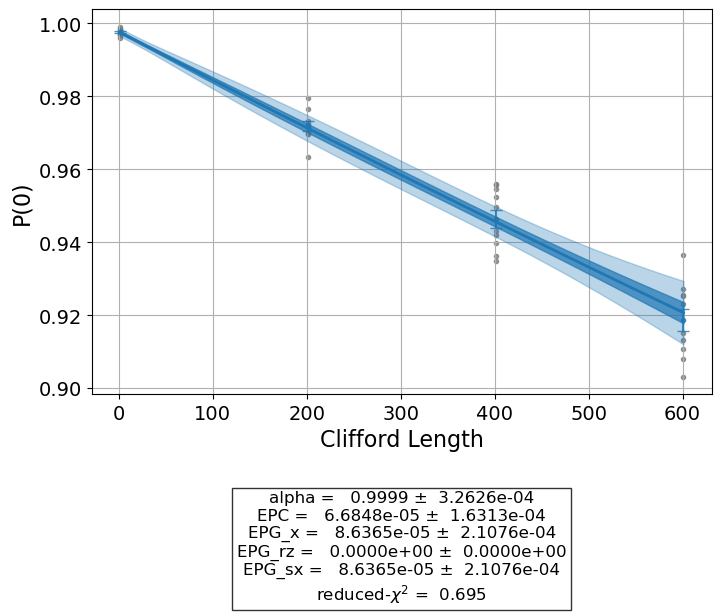

AnalysisResult
- name: @Parameters_RBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_rb_decay(x) = a * alpha ** x + b
 - success: True
 - number of function evals: 139
 - degree of freedom: 1
 - chi-square: 0.6949613119605155
 - reduced chi-square: 0.6949613119605155
 - Akaike info crit.: -1.0007738493220844
 - Bayesian info crit.: -2.841890765962413
 - init params:
  * a = 0.49771866676054444
  * alpha = 0.9997125672159332
  * b = 0.5
 - fit params:
  * a = 0.9977440523460708 ± 2.364737034828144
  * alpha = 0.9998663032095029 ± 0.00032626260549151566
  * b = 3.236344146613721e-23 ± 2.3647965639532194
 - correlations:
  * (a, b) = -0.9999999879915379
  * (alpha, b) = -0.9999344286372343
  * (a, alpha) = 0.9999339003716277
- quality: good
- extra: <2 items>
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: alpha
- value: 0.99987+/-0.00033
- χ²: 0.6949613119605155
- quality: good
- extra: <2 items>
- device_components

In [ ]:
# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()
results1 = expdata1.analysis_results()

# View result data
print("Gate error ratio: %s" % expdata1.experiment.analysis.options.gate_error_ratio)
display(expdata1.figure(0))
for result in results1:
    print(result)

In [13]:
lengths_2_qubit = np.arange(1, 200, 30)
lengths_1_qubit = np.arange(1, 800, 200)
num_samples = 10
seed = 1010
qubits = (1, 2)

# Run a 1-qubit RB experiment on qubits 1, 2 to determine the error-per-gate of 1-qubit gates
single_exps = BatchExperiment(
    [
        StandardRB((qubit,), lengths_1_qubit, num_samples=num_samples, seed=seed)
        for qubit in qubits
    ]
)
expdata_1q = single_exps.run(backend)

In [14]:
# Run an RB experiment on qubits 1, 2
exp_2q = StandardRB(qubits, lengths_2_qubit, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp_2q.analysis.set_options(epg_1_qubit=expdata_1q.analysis_results())

# Run the 2-qubit experiment
expdata_2q = exp_2q.run(backend)

In [ ]:
# View result data
print("Gate error ratio: %s" % expdata_2q.experiment.analysis.options.gate_error_ratio)
display(expdata_2q.figure(0))
for result in expdata_2q.analysis_results():
    print(result)

## Layer Fidelity Experiments

In [15]:
def to_edges(path):
    edges = []
    prev_node = None
    for node in path:
        if prev_node is not None:
            if G.has_edge(prev_node, node):
                edges.append((prev_node, node))
            else:
                edges.append((node, prev_node))
        prev_node = node
    return edges


def path_fidelity(path, correct_by_duration: bool = True, readout_scale: float = None):
    """Compute an estimate of the total fidelity of 2-qubit gates on a path.
    If `correct_by_duration` is true, each gate fidelity is worsen by
    scale = max_duration / duration, i.e. gate_fidelity^scale.
    If `readout_scale` > 0 is supplied, readout_fidelity^readout_scale
    for each qubit on the path is multiplied to the total fielity.
    The path is given in node indices form, e.g. [0, 1, 2].
    An external function `to_edges` is used to obtain edge list, e.g. [(0, 1), (1, 2)]."""
    path_edges = to_edges(path)
    max_duration = max(backend.target[twoq_gate][qs].duration for qs in path_edges)

    def gate_fidelity(qpair):
        duration = backend.target[twoq_gate][qpair].duration
        scale = max_duration / duration if correct_by_duration else 1.0
        # 1.25 = (d+1)/d) with d = 4
        return max(0.25, 1 - (1.25 * backend.target[twoq_gate][qpair].error)) ** scale

    def readout_fidelity(qubit):
        return max(0.25, 1 - backend.target["measure"][(qubit,)].error)

    total_fidelity = np.prod([gate_fidelity(qs) for qs in path_edges])
    if readout_scale:
        total_fidelity *= np.prod([readout_fidelity(q) for q in path]) ** readout_scale
    return total_fidelity


def flatten(paths, cutoff=None):  # cutoff not to make run time too large
    return [
        path
        for s, s_paths in paths.items()
        for t, st_paths in s_paths.items()
        for path in st_paths[:cutoff]
        if s < t
    ]

### Define and select the qubit chain

In [18]:

num_qubits_in_chain = 30
twoq_gate = "ecr"

coupling_map = backend.target.build_coupling_map(twoq_gate)
G = coupling_map.graph
print(f"Device {backend.name} Loaded with {backend.num_qubits} qubits")
print(f"Two Qubit Gate: {twoq_gate}")

paths = rx.all_pairs_all_simple_paths(
    G.to_undirected(multigraph=False),
    min_depth=num_qubits_in_chain,
    cutoff=num_qubits_in_chain,
)
paths = flatten(paths, cutoff=400)
if not paths:
    raise Exception(
        f"No qubit chain with length={num_qubits_in_chain} exists in {backend.name}. Try smaller num_qubits_in_chain."
    )

print(f"Selecting the best from {len(paths)} candidate paths (will take a few minutes)")
best_qubit_chain = max(paths, key=path_fidelity)
# from functools import partial
# best_qubit_chain = max(paths, key=partial(path_fidelity, correct_by_duration=True, readout_scale=1.0))
assert len(best_qubit_chain) == num_qubits_in_chain
print(f"Predicted LF from reported 2q-gate EPGs: {path_fidelity(best_qubit_chain)}")

print(np.array(best_qubit_chain))

Device ibm_rensselaer Loaded with 127 qubits
Two Qubit Gate: ecr
Selecting the best from 125918 candidate paths (will take a few minutes)
Predicted LF from reported 2q-gate EPGs: 0.8011883482016446
[11 12 17 30 31 32 36 51 50 49 55 68 67 66 73 85 84 83 82 81 80 79 78 77
 71 58 57 56 52 37]


### Decompose the chain into two disjoint layers

In [19]:
all_pairs = to_edges(best_qubit_chain)
two_disjoint_layers = [all_pairs[0::2], all_pairs[1::2]]
two_disjoint_layers

[[(12, 11),
  (17, 30),
  (31, 32),
  (36, 51),
  (49, 50),
  (68, 55),
  (67, 66),
  (73, 85),
  (83, 84),
  (82, 81),
  (80, 79),
  (78, 77),
  (58, 71),
  (57, 56),
  (37, 52)],
 [(17, 12),
  (31, 30),
  (36, 32),
  (51, 50),
  (55, 49),
  (68, 67),
  (66, 73),
  (84, 85),
  (83, 82),
  (81, 80),
  (79, 78),
  (77, 71),
  (57, 58),
  (52, 56)]]

### Create the experiment

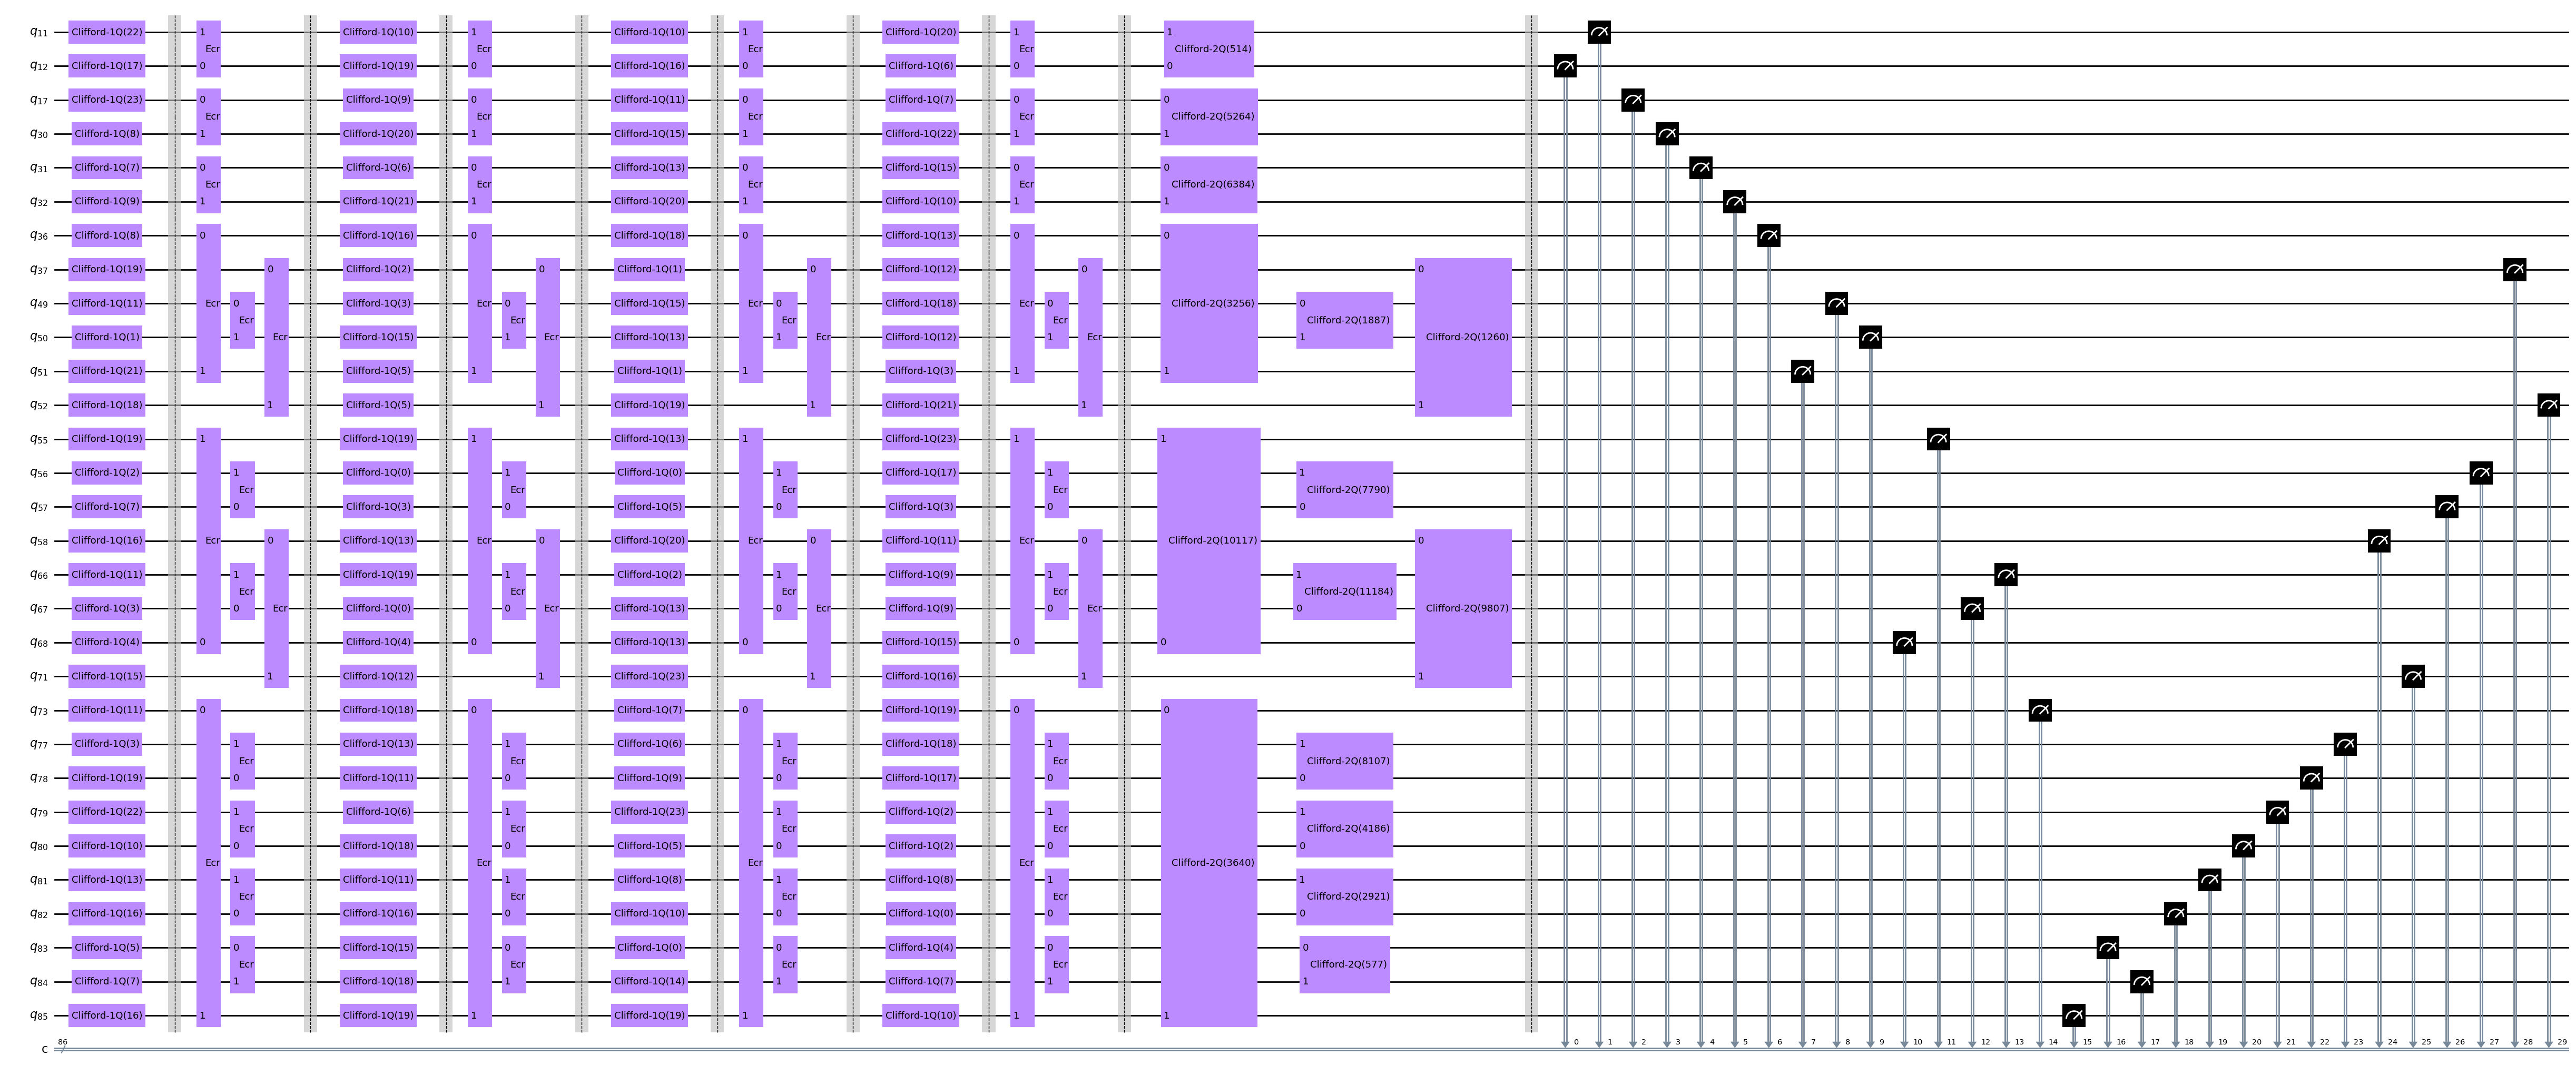

In [20]:
lfexp = LayerFidelity(
    physical_qubits=best_qubit_chain,
    two_qubit_layers=two_disjoint_layers,
    lengths=[2, 4, 8, 16, 24, 32, 48, 64, 72, 96, 128, 160, 192, 256, 320, 512],
    backend=backend,
    num_samples=32,
    seed=42,
    # two_qubit_gate="ecr",
    # one_qubit_basis_gates=["rz", "sx", "x"],
)

# set maximum number of circuits per job to avoid errors due to too large payload
lfexp.experiment_options.max_circuits = 144

# look at one of the first three 2Q direct RB circuits quickly
circ_iter = lfexp.circuits_generator()
first_three_circuits = list(next(circ_iter) for _ in range(3))
first_three_circuits[1].draw(output="mpl",
                             style="clifford", 
                             idle_wires=False, 
                             fold=-1)

In [21]:
# generate all circuits to run
circuits = lfexp.circuits()
print(f"{len(circuits)} circuits are generated.")

1024 circuits are generated.


In [ ]:
%%time
# number of shots per job
nshots = 1024

# Run the LF experiment (generate circuits and submit the job)
exp_data = lfexp.run(shots=nshots)
# exp_data.auto_save = True
print(f"Run experiment: ID={exp_data.experiment_id} with jobs {exp_data.job_ids}]")

In [ ]:
job = service.job(exp_data.job_ids[0])
JOB_DATE = job.creation_date

### Extract the Data and Plot the Results

In [ ]:
df = exp_data.analysis_results(dataframe=True)
df[(df.name == "ProcessFidelity")].head()

In [ ]:
for i in range(0, 5):
    display(exp_data.figure(i))

### Flag any bad runs

In [ ]:
pfdf = df[(df.name == "ProcessFidelity")]
pfdf[pfdf.value < 0.8]

In [ ]:
# find bad quality analysis results
pfdf[pfdf.quality == "bad"]

In [ ]:
# fill Process Fidelity values with zeros
pfdf = pfdf.fillna({"value": 0})

### Compute layer fidelity and EPLG

In [ ]:
# Compute LF by chain length assuming the first layer is full with 2q-gates
lf_sets, lf_qubits = two_disjoint_layers, best_qubit_chain
full_layer = [None] * (len(lf_sets[0]) + len(lf_sets[1]))
full_layer[::2] = lf_sets[0]
full_layer[1::2] = lf_sets[1]
full_layer = [(lf_qubits[0],)] + full_layer + [(lf_qubits[-1],)]

assert len(full_layer) == len(lf_qubits) + 1

In [ ]:
pfs = [pfdf.loc[pfdf[pfdf.qubits == qubits].index[0], "value"] for qubits in full_layer]
pfs = list(map(lambda x: x.n if x != 0 else 0, pfs))
pfs[0] = pfs[0] ** 2
pfs[-1] = pfs[-1] ** 2
np.array(pfs)

In [ ]:
# Approximate 1Q RB fidelities at both ends by the square root of 2Q RB fidelity at both ends.
# For example, if we have [(0, 1), (1, 2), (2, 3), (3, 4)] 2Q RB fidelities and if we want to compute a layer fidelity for [1, 2, 3],
# we approximate the 1Q filedities for (1,) and (3,) by the square root of 2Q fidelities of (0, 1) and (3, 4).
chain_lens = list(range(4, len(pfs), 2))
chain_fids = []
for length in chain_lens:
    w = length + 1  # window size
    fid_w = max(
        np.sqrt(pfs[s]) * np.prod(pfs[s + 1 : s + w - 1]) * np.sqrt(pfs[s + w - 1])
        for s in range(len(pfs) - w + 1)
    )
    chain_fids.append(fid_w)

In [ ]:
# Plot LF by chain length
plt.title(f"Backend: {backend.name}, {JOB_DATE.strftime('%Y/%m/%d %H:%M')}")
plt.plot(
    chain_lens,
    chain_fids,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1] * 1.05)
plt.ylim(0.95 * min(chain_fids), 1)
plt.ylabel("Layer Fidelity")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

In [ ]:
# Plot EPLG by chain length
num_2q_gates = [length - 1 for length in chain_lens]
chain_eplgs = [
    1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, chain_fids)
]
plt.title(f"Backend: {backend.name}, {JOB_DATE.strftime('%Y/%m/%d %H:%M')}")
plt.plot(
    chain_lens,
    chain_eplgs,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1] * 1.05)
plt.ylabel("Error per Layered Gates")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

## Computing the ground state of a deuteron

Adapted from: https://qiskit-community.github.io/qiskit-nature/tutorials/12_deuteron_binding_energy.html

In [26]:
def kronecker_delta_function(n: int, m: int) -> int:
    """An implementation of the Kronecker delta function.

    Args:
        n (int): The first integer argument.
        m (int): The second integer argument.

    Returns:
        Returns 1 if n = m, else returns 0.
    """
    return int(n == m)

def create_deuteron_hamiltonian(N: int,
                                hbar_omega: float = 7.0,
                                V_0: float = -5.68658111) -> SparsePauliOp:
    """Creates a version of the Deuteron Hamiltonian as a qubit operator.

    Args:
        N (int): An integer number that represents the dimension of the
            basis.
        hbar_omega (float, optional): The value of the product of hbar and omega. Defaults to 7.0.
        V_0 (float, optional): The value of the potential energy. Defaults to -5.68658111.

    Returns:
        SparsePauliOp: The qubit-space Hamiltonian that represents the Deuteron.
    """
    hamiltonian_terms = {}
    for m in range(N):
        for n in range(N):

            label = "+_{} -_{}".format(str(n), str(m))
            coefficient_kinect = (hbar_omega / 2) * (
                (2 * n + 3 / 2) * kronecker_delta_function(n, m)
                - np.sqrt(n * (n + (1 / 2))) * kronecker_delta_function(n, m + 1)
                - np.sqrt((n + 1) * (n + (3 / 2)) * kronecker_delta_function(n, m - 1))
            )
            hamiltonian_terms[label] = coefficient_kinect

            coefficient_potential = (
                V_0 * kronecker_delta_function(n, 0) * kronecker_delta_function(n, m)
            )
            hamiltonian_terms[label] += coefficient_potential

    hamiltonian = FermionicOp(hamiltonian_terms, num_spin_orbitals=N)
    mapper = JordanWignerMapper()
    qubit_hamiltonian = mapper.map(hamiltonian)
    if not isinstance(qubit_hamiltonian, SparsePauliOp):
        qubit_hamiltonian = qubit_hamiltonian.primitive

    return qubit_hamiltonian

In [53]:
def get_timestamp():
    """
    Returns the current UTC timestamp in ISO-8601 format.

    Returns
    -------
    str
    """
    return dt.datetime.now(dt.UTC).isoformat()

def transpile_and_apply(ansatz, hamiltonian, backend, optimization_level=1, passmanager=None):
    """
    Transpile the ansatz circuit and apply the Hamiltonian observable to the backend layout.
    """

    if not passmanager:
        passmanager = generate_preset_pass_manager(target=backend.target,
                                                   optimization_level=optimization_level)
    
    isa_ansatz = passmanager.run(ansatz)
    isa_hamiltonian = hamiltonian.apply_layout(isa_ansatz.layout)

    return isa_ansatz, isa_hamiltonian

def cost_func(params, ansatz, hamiltonian, estimator, session, metadata_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    # Create the PUB for this parameter set
    pub = (ansatz, [hamiltonian], [params])

    # Submit the job to the session    
    job = estimator.run(pubs=[pub])

    # Grab the job ID so we can retrieve it later
    job_id = job.job_id()
    metadata_dict['job_ids'].append(job_id)

    # Wait on the result
    result = job.result()

    # Get the expectation value and and std. deviation
    energy = result[0].data.evs[0]
    err = result[0].data.stds[0]

    metadata_dict["iters"] += 1
    metadata_dict["params"].append(params)
    metadata_dict["energy"].append((energy, err))
    metadata_dict["job_info"].append(job.metrics())

    if metadata_dict["iters"] >= metadata_dict["maxiter"]:
        session.close()
    
    print(f"Iters. done: {metadata_dict['iters']} [Energy: {energy} +/- {err}]")

    return energy

def solve_vqe(backend, 
              cost_func,
              initial_point,
              metadata_dict,
              shots=None,
              method='COBYLA',
              tol=3e-1,
              maxiter=100,
              max_time=3600):

    # Create a qiskit runtime session that keeps the channel to the machine
    # open during the optimization loop.
    with ibm.Session(backend=backend, max_time=max_time) as session:

        metadata_dict['session_id'] = session.session_id
        
        metadata_dict['start_time'] = get_timestamp()
        metadata_dict['params'].append(initial_point)

        # Create the estimator and assign the shot value
        estimator = ibm.EstimatorV2(mode=session)
        estimator.options.default_precision = tol
        estimator.options.resilience_level = 2

        try:
            # Execute the minimization
            res = minimize(
                cost_func,
                x0,
                args=(isa_ansatz, 
                      isa_hamiltonian, 
                      estimator, 
                      session, 
                      metadata_dict),
                method=method,
                tol=tol
            )

        # If the session closes unexpectedly, clean up gracefully
        except ibm.IBMError as error:

            print("Session Error...returing")
            
            metadata_dict['end_time'] = get_timestamp()
            return None, metadata_dict, error
        
        metadata_dict['completed'] = True
        metadata_dict['end_time'] = get_timestamp()

    return res, metadata_dict

### Compute the reference values of the Deuteron Hamiltonian

In [54]:
N = 7
deuteron_hamiltonians = [create_deuteron_hamiltonian(i) for i in range(1, N+1)]

In [55]:
twolocal_ansatze = []
for i in range(1, N+1):
    ansatz = TwoLocal(
        deuteron_hamiltonians[i - 1].num_qubits,
        rotation_blocks=["rz", "ry"],
        entanglement_blocks=["cx", "cz"],
        entanglement="linear",
        reps=i,
        initial_state=None,
    )
    twolocal_ansatze.append(ansatz)

In [56]:
reference_values = []
print("Exact binding energies calculated through numpy.linalg.eigh \n")
for i, hamiltonian in enumerate(deuteron_hamiltonians):
    eigenvalues, eigenstates = np.linalg.eigh(hamiltonian.to_matrix())
    reference_values.append(eigenvalues[0])
    print("Exact binding energy for H_{}: {}".format(i + 1, eigenvalues[0]))

Exact binding energies calculated through numpy.linalg.eigh 

Exact binding energy for H_1: -0.43658110999999966
Exact binding energy for H_2: -1.7491598763215301
Exact binding energy for H_3: -2.0456708984064416
Exact binding energy for H_4: -2.143981030799861
Exact binding energy for H_5: -2.1835917100257545
Exact binding energy for H_6: -2.2015681487933
Exact binding energy for H_7: -2.2104158253527775


In [57]:
order = 2

isa_ansatz, isa_hamiltonian = transpile_and_apply(twolocal_ansatze[order-1],
                                                  deuteron_hamiltonians[order-1],
                                                  backend=backend,
                                                  optimization_level=3)

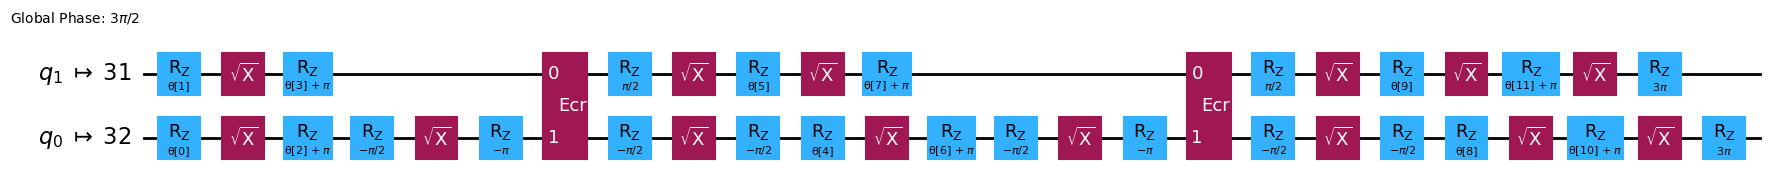

In [58]:
isa_ansatz.draw(output='mpl', idle_wires=False)

In [62]:
maxiter = 25
shots = 10000
maxtime = 1800

# Generate an initial parameter guess
num_params = isa_ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

depth = isa_ansatz.depth()
depth_2q = isa_ansatz.depth(lambda x: x[0].num_qubits == 2)
print(f"Total Circuit depth = {depth}")
print(f"2-Qubit Circuit depth = {depth_2q}")

# Initialize the data tracking dictionary
metadata_dict = {
    'session_id': None,
    'iters': 0,
    'backend': backend.name,
    'maxiter': maxiter,
    'params': [],
    'energy': [],
    'job_ids': [],
    'job_info':[],
    'start_time': None,
    'end_time': None,
    'completed': False
}

Total Circuit depth = 25
2-Qubit Circuit depth = 2


/tmp/ipykernel_905341/4186385198.py:10: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  depth_2q = isa_ansatz.depth(lambda x: x[0].num_qubits == 2)


In [ ]:
print(
    "Running using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper \n"
)

# Run the problem in a Qiskit session
result, metadata = solve_vqe(backend,
                             cost_func,
                             x0,
                             metadata_dict,
                             shots=shots,
                             maxiter=maxiter,
                             max_time=maxtime)

Running using Estimator for H_1, H_2 and H_3 with the ansatz given in the reference paper 

